# Initiation of notebook


First get the repo from github to experiment on its models


we have 2 models to experiment on


```model_1```:
Denoising autoencoder + CNN 

```model_2```:
Encoder of the DAE + CNN

In [0]:

from google.colab import drive
drive.mount('/content/gdrive/') 


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
%cd gdrive/My\ Drive/ColabFiles/AdversarialAttacks/

[Errno 2] No such file or directory: 'gdrive/My Drive/ColabFiles/AdversarialAttacks/'
/content/gdrive/My Drive/ColabFiles/AdversarialAttacks


In [0]:
!git config --global user.email "jafer.ba@Gmail.com"

!git fetch --all

!git reset --hard origin/master


Fetching origin
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 6 (delta 4), reused 6 (delta 4), pack-reused 0
Unpacking objects: 100% (6/6), done.
From https://github.com/JafarBadour/Adversarial-Attacks-on-Neural-Networks
   4afee1c..00f1426  master     -> origin/master
Checking out files: 100% (25/25), done.
HEAD is now at 00f1426 fix: fixed the problem with adversarial_utils.py generate adversarial examples


In [0]:
ls Models/ -la

total 8850
drwx------ 2 root root    4096 Apr 25 18:23 DAE/
-rw------- 1 root root  105216 Apr 25 18:23 DAE.h
-rw------- 1 root root  105304 May 15 10:55 DAE.h5
-rw------- 1 root root   17168 May 15 10:55 decoder.h5
-rw------- 1 root root 4320248 May 15 10:55 denoising_autoencoder_ann.h5
-rw------- 1 root root 4465816 May 15 10:55 encoder_ann.h5
-rw------- 1 root root   43176 May 15 10:55 encoder.h5


In [0]:

!pip install -r requirements.txt

     |████████████████████████████████| 245kB 3.5MB/s 
     |████████████████████████████████| 460kB 11.0MB/s 
     |████████████████████████████████| 71kB 6.1MB/s 
  Created wheel for foolbox: filename=foolbox-1.8.0-cp36-none-any.whl size=262064 sha256=6c781ff8ccfd78d11d39dcd07ca517507f968188718769f525735b96e77d0600
  Stored in directory: /root/.cache/pip/wheels/d7/e7/c8/153284a6e5e5c3fd4da42a8453175b45e2e185e8b5a09ced06
Successfully built foolbox


# RUN ATTACKS


on these two models



In [0]:
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 1.x

import tensorflow as tf
from tensorflow import keras

In [0]:
tf.__version__

'1.15.2'

In [0]:
print(foolbox.attacks.DeepFoolL2Attack)

<module 'foolbox.attacks' from '/usr/local/lib/python3.6/dist-packages/foolbox/attacks/__init__.py'>


In [0]:

import foolbox
from utils.dnns import AnyDNN
# Import DAE_ANN

DAE_ANN = AnyDNN('./Models/denoising_autoencoder_ann.h5').get_keras_model()

fmodel = foolbox.models.TensorFlowModel.from_keras(DAE_ANN, bounds=(0, 1))
attack_criterion = foolbox.criteria.Misclassification()
attack_fn = foolbox.attacks.DeepFoolL2Attack(fmodel, criterion=attack_criterion, distance=foolbox.distances.Linfinity)


In [0]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images = train_images/255.0
test_images = test_images/255.0
train_images = train_images.reshape(len(train_images),28,28,1)
test_images = test_images.reshape(len(test_images),28,28,1)
test_loss, test_acc = DAE_ANN.evaluate(test_images, test_labels)
print('Model accuracy based on test data:', test_acc)
del fashion_mnist

4423680/4422102 [==============================] - 0s 0us/step

10000/10000 [==============================] - 8s 754us/step
Model accuracy based on test data: 0.8661999702453613


In [0]:
from utils.adversarial_utils import generate_adversarial_data
N = 1000 # 6000
x_images = train_images[0:N, :]
print(x_images.shape)
(x_train_adv_images, x_train_adv_perturbs, x_train_labels) = \
generate_adversarial_data(original_images = x_images, predictions = DAE_ANN.predict(x_images), attack_fn = attack_fn, verbose=False)


(1000, 28, 28, 1)


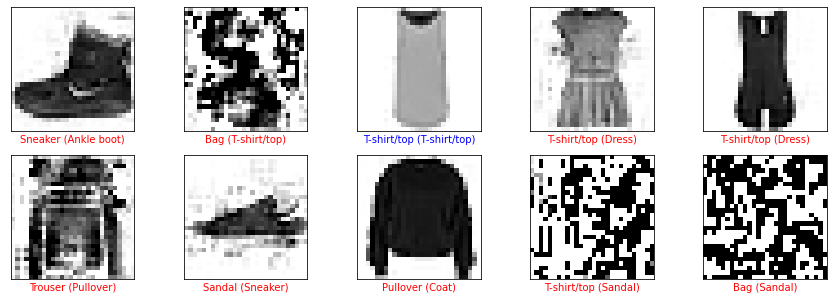

In [0]:
def plot_sample_images(model, images, expected_labels, class_names):
    predictions = model.predict(images)
    plt.figure(figsize=(15, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        shape = (images[i].shape[0], images[i].shape[1])
        plt.imshow(images[i].reshape(shape), cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions[i])
        if predicted_label == expected_labels[i]:
            color = 'blue'
        else:
            color = 'red'

        plt.xlabel("{} ({})".format(class_names[predicted_label],
                                    class_names[expected_labels[i]]),
                   color=color)



plot_sample_images(DAE_ANN, x_train_adv_images, x_train_labels, class_names)

Save the array of the adversarial examples in files

In [0]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [0]:
import numpy as np
import json
np.save('./data/DAE_CNN/adversarial_examples',x_train_adv_images)
for key in x_train_adv_perturbs.keys():
  #print(x_train_adv_perturbs[key][1:3])
  np.save(f'./data/DAE_CNN/adversarial_perturbation_{key}',x_train_adv_perturbs[key])
np.save('./data/DAE_CNN/adversarial_real_labels',x_train_labels)

We can notice from above that there are huge perturbations in order to make the adversarial examples work 


lets measure that


In [0]:
import numpy as np
Xx_train_adv_images = np.load('./data/DAE_CNN/adversarial_examples.npy')

keys = ['l2_norms','l0_norms', 'linf_norms', 'foolbox_diff']

Xx_train_adv_perturbs = dict(zip(keys,map(lambda x:np.load(f'./data/DAE_CNN/adversarial_perturbation_{x}.npy'),keys)))

Xx_train_labels = np.load('./data/DAE_CNN/adversarial_real_labels.npy')

# DeepFool minimizes $L_2$ norm so lets measure it as a distribution



I will plot it in a histogram with mean and std as numbers 

*   List item
*   List item



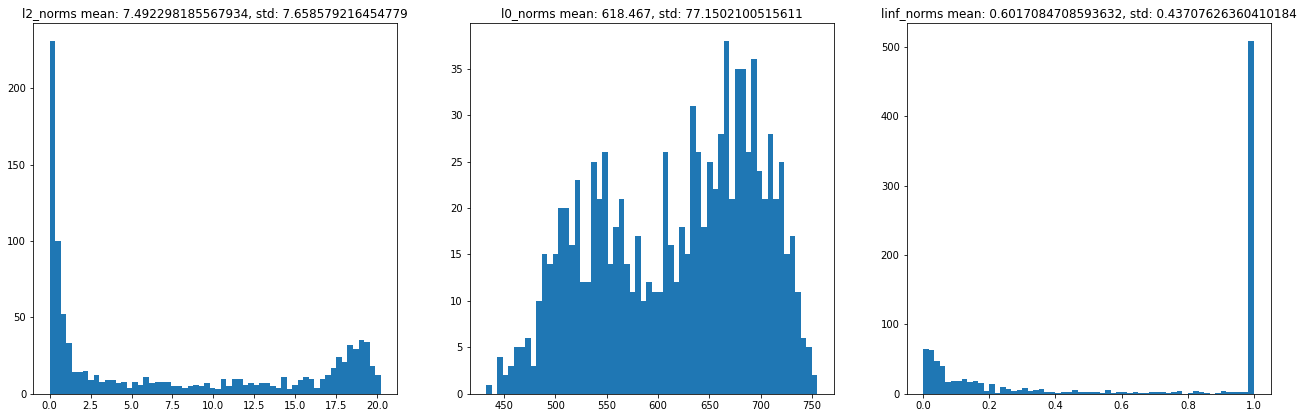

In [0]:
import matplotlib.pyplot as plt

cnt = 1
for key in keys[:-1]:
  plt.rcParams["figure.figsize"] = (30, 15)
  plt.subplot(2, 4, cnt)
  cnt += 1
  x =  Xx_train_adv_perturbs[key]
  
  
  import matplotlib.pyplot as plt

  plt.hist(x, bins=60)
  plt.title(f'{key} mean: {x.mean()}, std: {x.std()}')
plt.show()

# Confidence 

(400, 28, 28, 1)


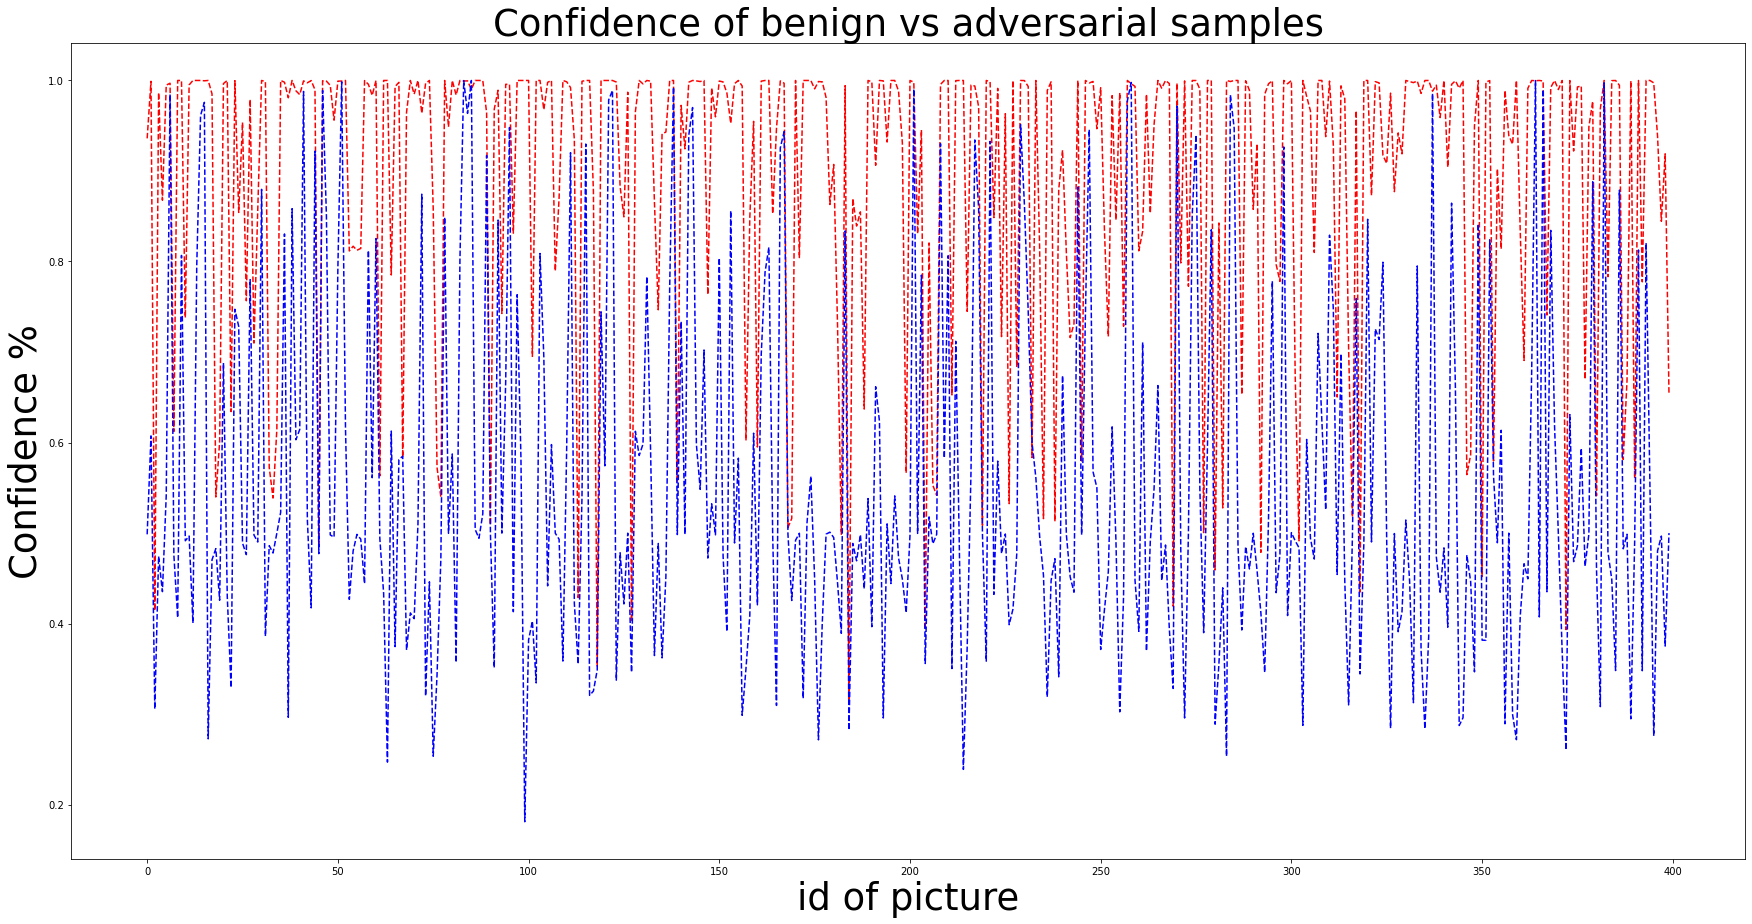

In [0]:
from utils.plot import plot_confidence

plot_confidence(Xx_train_adv_images[:400], DAE_ANN, train_images)

# ENCODER + ANN


lets see the robustness of encoder + ann neural network



In [0]:

import foolbox
from utils.dnns import AnyDNN
# Import DAE_ANN

E_ANN = AnyDNN('./Models/encoder_ann.h5').get_keras_model()

fmodel = foolbox.models.TensorFlowModel.from_keras(E_ANN, bounds=(0, 1))
attack_criterion = foolbox.criteria.Misclassification()
attack_fn = foolbox.attacks.DeepFoolL2Attack(fmodel, criterion=attack_criterion, distance=foolbox.distances.Linfinity)


# Lets evaluate its test accuracy



with model.evaluate

In [0]:
E_ANN.evaluate(test_images, test_labels)[1]

10000/10000 [==============================] - 1s 132us/step


0.8608999848365784

In [0]:
from utils.adversarial_utils import generate_adversarial_data
x_images = train_images[0:N, :]
print(x_images.shape)
(x_train_adv_images, x_train_adv_perturbs, x_train_labels) = \
generate_adversarial_data(original_images = x_images, predictions = E_ANN.predict(x_images), attack_fn = attack_fn, verbose=False)


(1000, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:148: UserWarning: DeepFoolL2Attack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


# How successful was DeepFoolL2Attack

!

In [0]:
print('Attack success rate : ', len(x_train_adv_images)*100.0/N, " %")


Attack success rate :  16.55  %


In [0]:
import numpy as np
import json
np.save('./data/E_CNN/adversarial_examples',x_train_adv_images)
for key in x_train_adv_perturbs.keys():
  #print(x_train_adv_perturbs[key][1:3])
  np.save(f'./data/E_CNN/adversarial_perturbation_{key}',x_train_adv_perturbs[key])
np.save('./data/E_CNN/adversarial_real_labels',x_train_labels)

In [0]:
import numpy as np
Xx_train_adv_images = np.load('./data/E_CNN/adversarial_examples.npy')

keys = ['l2_norms','l0_norms', 'linf_norms', 'foolbox_diff']

Xx_train_adv_perturbs = dict(zip(keys,map(lambda x:np.load(f'./data/E_CNN/adversarial_perturbation_{x}.npy'),keys)))

Xx_train_labels = np.load('./data/E_CNN/adversarial_real_labels.npy')

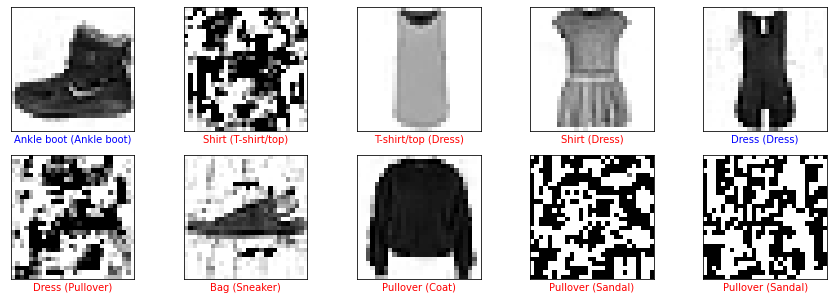

In [0]:
plot_sample_images(E_ANN, x_train_adv_images, x_train_labels, class_names)

# DeepFool minimizes $L_2$ norm so lets measure it as a distribution


I will plot it in a histogram with mean and std as numbers 

*   List item
*   List item



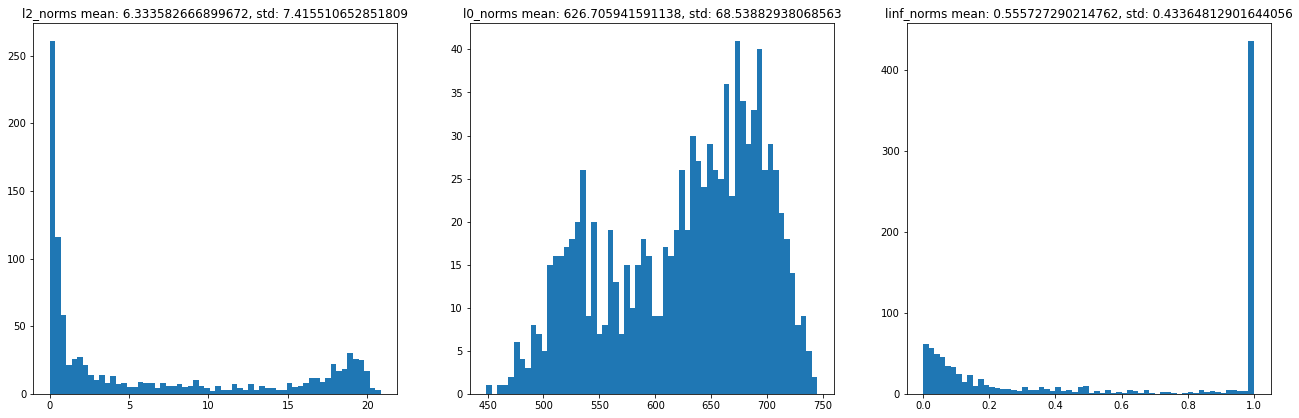

In [0]:
import matplotlib.pyplot as plt

cnt = 1
for key in keys[:-1]:
  plt.rcParams["figure.figsize"] = (30, 15)
  plt.subplot(2, 4, cnt)
  cnt += 1
  x =  Xx_train_adv_perturbs[key]
  
  
  import matplotlib.pyplot as plt

  plt.hist(x, bins=60)
  plt.title(f'{key} mean: {x.mean()}, std: {x.std()}')
plt.show()

(993, 28, 28, 1)


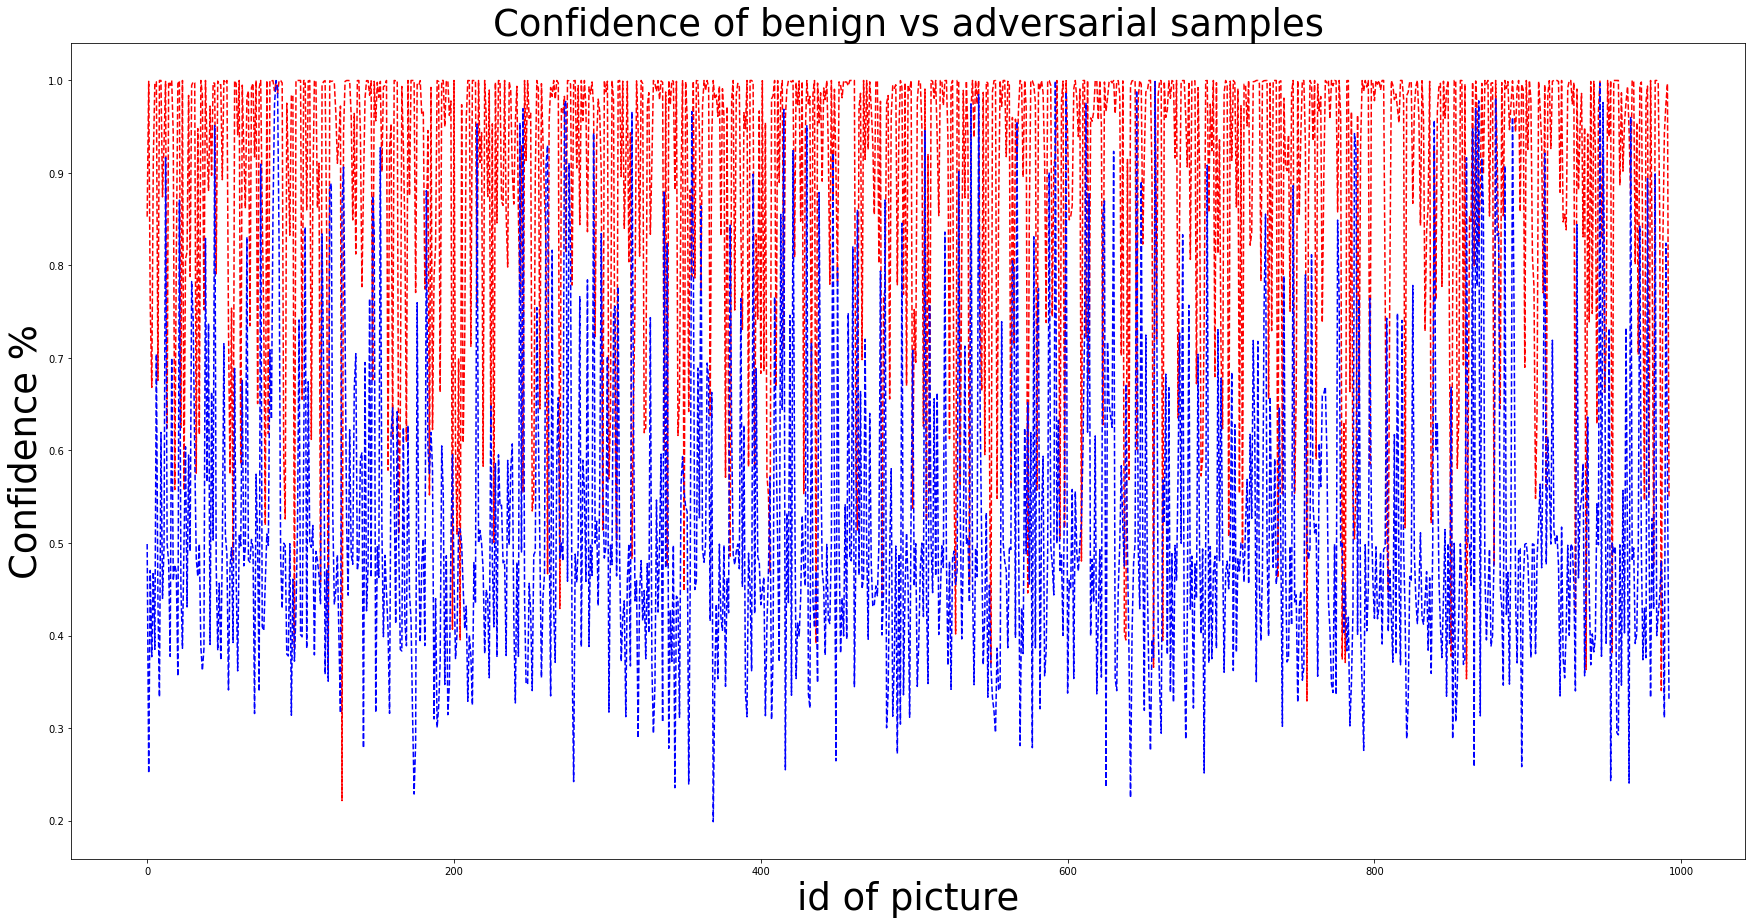

In [0]:
from utils.plot import plot_confidence

plot_confidence(x_train_adv_images, E_ANN, train_images)

#  tensorboard


In [0]:
%load_ext tensorboard
